In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import Input

from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_csv('./data/df_final.csv')

In [4]:
df.head()

,STATION,PRCP,TMAX,TMIN,Year,County,Yield(Unit/Acre)
0,USC00048351,0.0,NaN,NaN,1980,Sonoma,3.34
1,USC00048351,0.0,53.0,38.0,1981,Sonoma,3.39
2,USC00048351,0.5,51.0,35.0,1982,Sonoma,4.00
3,USC00048351,0.0,48.0,32.0,1983,Sonoma,3.14
4,USC00048351,0.0,63.0,36.0,1984,Sonoma,3.81


In [5]:
df.isna().sum()

STATION              0
PRCP                26
TMAX                52
TMIN                55
Year                 0
County               0
Yield(Unit/Acre)     0
dtype: int64

In [6]:
df['PRCP'] = df['PRCP'].transform(lambda x: x.fillna(x.median()))
df['TMIN'] = df['TMIN'].transform(lambda x: x.fillna(x.median()))
df['TMAX'] = df['TMAX'].transform(lambda x: x.fillna(x.median()))

In [7]:
df.isna().sum()

STATION             0
PRCP                0
TMAX                0
TMIN                0
Year                0
County              0
Yield(Unit/Acre)    0
dtype: int64

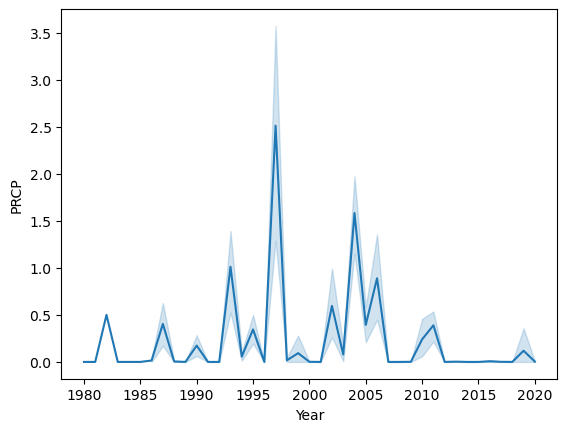

In [8]:
sns.lineplot(data=df, x='Year', y='PRCP');

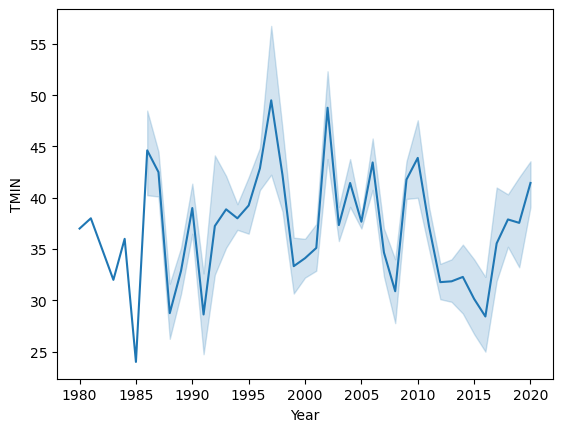

In [9]:
sns.lineplot(data=df, x='Year', y='TMIN');

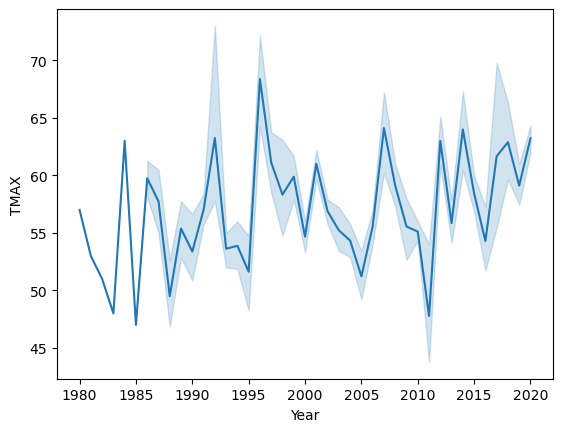

In [10]:
sns.lineplot(data=df, x='Year', y='TMAX');

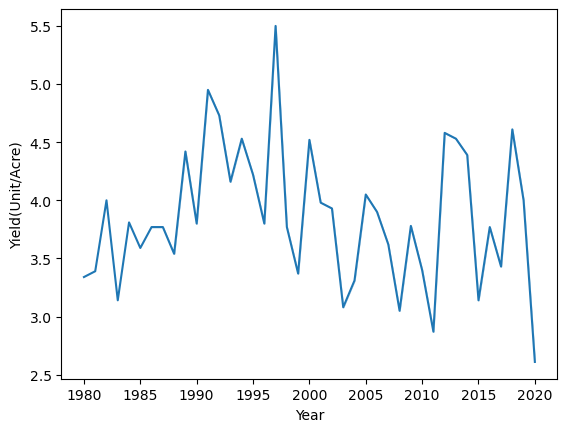

In [11]:
sns.lineplot(data=df, x='Year', y='Yield(Unit/Acre)');

In [11]:
# only drop a column that won't have an impact on my selection
df = df.drop(['County'], axis=1)

In [12]:
stations = df.STATION.unique()
print(len(stations))
print(stations)

9
['USC00048351' 'USC00047965' 'USC00043578' 'USC00043875' 'USC00046370'
 'USC00046826' 'USC00043191' 'USC00041838' 'USW00023213']


In [13]:
df['STATION'] = df['STATION'].str.slice(6, 11)

In [14]:
df['STATION'] = df['STATION'].astype(int)

In [15]:
df.dtypes

STATION               int64
PRCP                float64
TMAX                float64
TMIN                float64
Year                  int64
Yield(Unit/Acre)    float64
dtype: object

In [16]:
df.head()

,STATION,PRCP,TMAX,TMIN,Year,Yield(Unit/Acre)
0,48351,0.0,57.0,37.0,1980,3.34
1,48351,0.0,53.0,38.0,1981,3.39
2,48351,0.5,51.0,35.0,1982,4.00
3,48351,0.0,48.0,32.0,1983,3.14
4,48351,0.0,63.0,36.0,1984,3.81


In [45]:
# Encode categorical 'STATION' column
label_encoder = LabelEncoder()
df['STATION'] = label_encoder.fit_transform(df['STATION'])

In [46]:
df.STATION.unique()

array([7, 6, 2, 3, 4, 5, 1, 0, 8])

In [18]:
# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['STATION', 'PRCP', 'TMAX', 'TMIN', 'Yield(Unit/Acre)']])
scaled_df = pd.DataFrame(scaled_data, columns=['STATION', 'PRCP', 'TMAX', 'TMIN', 'Yield(Unit/Acre)'])

In [21]:
# Prepare sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps, :-1])  # Sequence of features
        y.append(data[i + n_steps, -1])     # Target yield value after the sequence
    return np.array(X), np.array(y)

In [22]:
n_steps = 3
X, y = create_sequences(scaled_df.values, n_steps)

In [25]:
print(X.shape, y.shape)

(298, 3, 4) (298,)


In [28]:
# https://keras.io/api/models/model_training_apis/
model = Sequential()
model.add(Input(shape=(n_steps, X.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
# https://faroit.com/keras-docs/1.1.0/optimizers/
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1182  
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0685
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0470 
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0459 
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0556
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0478 
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0553 
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0455
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0471 
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0501
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0488
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.0435
Epoch 13/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 0.0464
Epoch 14/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0504
Epoch 15/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step 

In [41]:
def predict_yield(model, scaler, label_encoder, station, prcp, tmax, tmin, n_steps=3):
    
    # Prepare and scale the new data
    new_data = np.array([[station, prcp, tmax, tmin, 0]])  # Initial Yield value as 0
    scaled_new_data = scaler.transform(new_data)
    
    # Prepare the sequence for prediction
    X_new = []
    for i in range(n_steps):
        X_new.append(scaled_new_data[0][:4])  # Only the feature columns
    X_new = np.array(X_new).reshape((1, n_steps, -1))
    
    # Make the prediction
    yield_prediction_scaled = model.predict(X_new)
    
    # Inverse transform the scaled yield prediction to get the original yield value
    unscaled_prediction = scaler.inverse_transform([[0, 0, 0, 0, yield_prediction_scaled[0][0]]])[0][-1]
    
    return unscaled_prediction

In [42]:
# Example of using the function with new data
station = 7 # 48351
prcp = 0.1
tmax = 60.0
tmin = 40.0

predicted_yield = predict_yield(model, scaler, label_encoder, station, prcp, tmax, tmin)
print(f"Predicted Yield (Unit/Acre): {predicted_yield:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted Yield (Unit/Acre): 3.73


/Users/kristinmayer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [43]:
station = 0 # 48351
prcp = 0.1
tmax = 60.0
tmin = 40.0

predicted_yield = predict_yield(model, scaler, label_encoder, station, prcp, tmax, tmin)
print(f"Predicted Yield (Unit/Acre): {predicted_yield:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted Yield (Unit/Acre): 3.57


/Users/kristinmayer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [44]:
station = 2 # 48351
prcp = 0.1
tmax = 60.0
tmin = 40.0

predicted_yield = predict_yield(model, scaler, label_encoder, station, prcp, tmax, tmin)
print(f"Predicted Yield (Unit/Acre): {predicted_yield:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Yield (Unit/Acre): 3.69


/Users/kristinmayer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
